<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60">

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'>


Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej".   
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

# Statistical machine learning - Notebook 11, version for students
**Author: Michał Ciach**  
**Date: 5.01.2022**

## Description
 

In today's class, we will learn how to use *decision trees* and *random forests*, some of the most popular classification algorithms.  
We will apply it to classify breast cancer as either benign or malignant based on data from biopsies, where a sample of a tumour is analyzed under a microscope and described by a medical professional.     

In contrast to regression models and Linear Discriminant Analysis, decision trees are *non-parametric*, i.e. they do not assume any distribution of variables.  
This is both an advantage and a disadvantage.  
Non-parametric methods are easier to use and more robust to misspecification of the model.     
However, it's worth to remember that if we specify the underlying probability distributions correctly, then using a parametric model will most likely result in a better accuracy, because the model can use this additional information about the data set to improve its predictions.  
Parametric models also typically allow us to better estimate the uncertainty of the prediction and estimation, which is a huge advantage of statistical machine learning compared to more algorithmical approaches.  

## Data & library imports

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

In [3]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1a1gfcwAWPEqbPJ3IM2LeAQqr5TeBHqiI

Downloading...
From: https://drive.google.com/uc?id=1a1gfcwAWPEqbPJ3IM2LeAQqr5TeBHqiI
To: /content/breast-cancer-wisconsin.data
100% 19.9k/19.9k [00:00<00:00, 34.8MB/s]


**Exercise 0.** Download the breast cancer biopsy data from [this link](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/).  
Find a file with the biopsy data set and a file that describes the contents of the data set.   
Based on the latter file, figure out what are the possible classes, how they are encoded, and which columns should be used for classification.   
Is this data suitable for logistic regression? Why/why not?


Upload the data set into the notebook environment. 
Load the data into a Pandas data frame.    
Use the `column_names` list below to assign column names to the data frame.  
Check if the data requires pre-processing and, if yes, do it. You may want to inspect the `df.dtypes` attribute of a data frame and use the `unique()` method to print all different values in a given column.  

Split the data set into two variables: a data frame `X` with independent variables (i.e. the columns that you will use as predictors) and a vector `y` with the dependent variable (i.e. the cancer class label).  
Split both data frames into training and testing data sets using the `train_test_split` function from the `sklearn` package, so that the test data set has 1/3 of all observations and the training data set has the rest.  



In [2]:
column_names = ['Sample code number',
                'Clump Thickness',
                'Uniformity of Cell Size',
                'Uniformity of Cell Shape',
                'Marginal Adhesion',
                'Single Epithelial Cell Size',
                'Bare Nuclei',
                'Bland Chromatin',
                'Normal Nucleoli',
                'Mitoses',
                'Class']

In [13]:
data = pd.read_csv('breast-cancer-wisconsin.data', names=column_names, delimiter=',', dtype={'Sample code number': str})
data

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


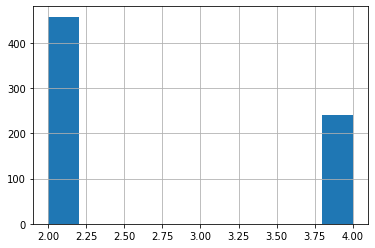

In [12]:
data['Class'].hist()

In [14]:
data.dtypes

Sample code number             object
Clump Thickness                 int64
Uniformity of Cell Size         int64
Uniformity of Cell Shape        int64
Marginal Adhesion               int64
Single Epithelial Cell Size     int64
Bare Nuclei                    object
Bland Chromatin                 int64
Normal Nucleoli                 int64
Mitoses                         int64
Class                           int64
dtype: object

In [17]:
data['Bare Nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [18]:
data['Bare Nuclei'].replace({'?': np.NaN}, inplace=True)

In [19]:
data['Bare Nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', nan, '5', '8', '6'],
      dtype=object)

In [21]:
data = data.dropna()

In [25]:
data = data.astype({'Bare Nuclei': 'int64'})

In [26]:
data.dtypes

Sample code number             object
Clump Thickness                 int64
Uniformity of Cell Size         int64
Uniformity of Cell Shape        int64
Marginal Adhesion               int64
Single Epithelial Cell Size     int64
Bare Nuclei                     int64
Bland Chromatin                 int64
Normal Nucleoli                 int64
Mitoses                         int64
Class                           int64
dtype: object

In [30]:
y = data['Class']
cols =[x for x in column_names if (x != 'Sample code number' and x != 'Class')]
x = data[cols]

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

## The CART algorithm

Before moving to random forests, we will learn how to use single trees for classification.  
We will focus on an algorithm called Classification and Regression Trees (CART).  

The main advantages of using a single decision tree are that it is highly explainable (we know exactly how classification is performed) and computationally effective. In particular, they allow for a very fast classification of new observations, which has a crucial importance e.g. in online trading or real-time bidding.   

However, decision trees are prone to overfitting, and may not be very accurate. One of the major disadvantages, however, is that the structure of the tree is rather unstable - perturbations in the data set, such as we've seen in the previous class when we were learning about logistic regression, can introduce large changes to the tree.  

**Exercise 1.** Fit a CART model to the training data set using the `DecisionTreeClassifier()` function from `sklearn` with default options.  
Check the training and test errors. Is the test error satisfactory?  
Do the errors change between runs? If so, read the documenation to figure out why.      

Visualize the tree using the `plot_tree` function from `sklearn`. Is it easy to interpret? How many features need to be evaluated to classify the tumor? Would such a classification procedure be useful for medical professionals in a daily clinical practice?   

Limit the complexity of the tree by setting the `max_depth` parameter to the value of your choice and compare your results. Did it change the test accuracy? Is it more useful in practice? What features of a biopsy are most important for determining if the tumor is malignant? 

Use the `confusion_matrix` function from `sklearn` to generate a confusion matrix for the classifer. Do you detect a bias in the results? What is the probability that, if a tumor is classified as benign, it is in fact malignant, and the other way around? Is it good in this case? 

In [39]:
from sklearn import metrics

In [36]:
clf = DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [37]:
confusion_matrix(y_test, y_pred)

array([[139,   3],
       [ 10,  74]])

In [40]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9424778761061947


[Text(0.5192307692307693, 0.9444444444444444, 'X[1] <= 3.5\ngini = 0.448\nsamples = 457\nvalue = [302, 155]'),
 Text(0.28846153846153844, 0.8333333333333334, 'X[5] <= 4.5\ngini = 0.12\nsamples = 313\nvalue = [293, 20]'),
 Text(0.15384615384615385, 0.7222222222222222, 'X[6] <= 3.5\ngini = 0.027\nsamples = 291\nvalue = [287, 4]'),
 Text(0.07692307692307693, 0.6111111111111112, 'X[8] <= 6.0\ngini = 0.007\nsamples = 283\nvalue = [282, 1]'),
 Text(0.038461538461538464, 0.5, 'gini = 0.0\nsamples = 281\nvalue = [281, 0]'),
 Text(0.11538461538461539, 0.5, 'X[4] <= 2.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.07692307692307693, 0.3888888888888889, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.15384615384615385, 0.3888888888888889, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.23076923076923078, 0.6111111111111112, 'X[5] <= 2.5\ngini = 0.469\nsamples = 8\nvalue = [5, 3]'),
 Text(0.19230769230769232, 0.5, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.2692307692307692,

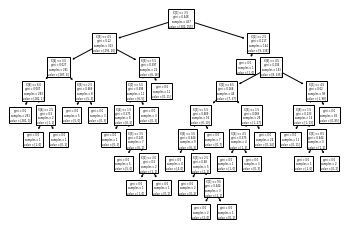

In [41]:
plot_tree(clf)

In [43]:
!pip install graphviz
!pip install pydotplus

In [45]:
!pip install six

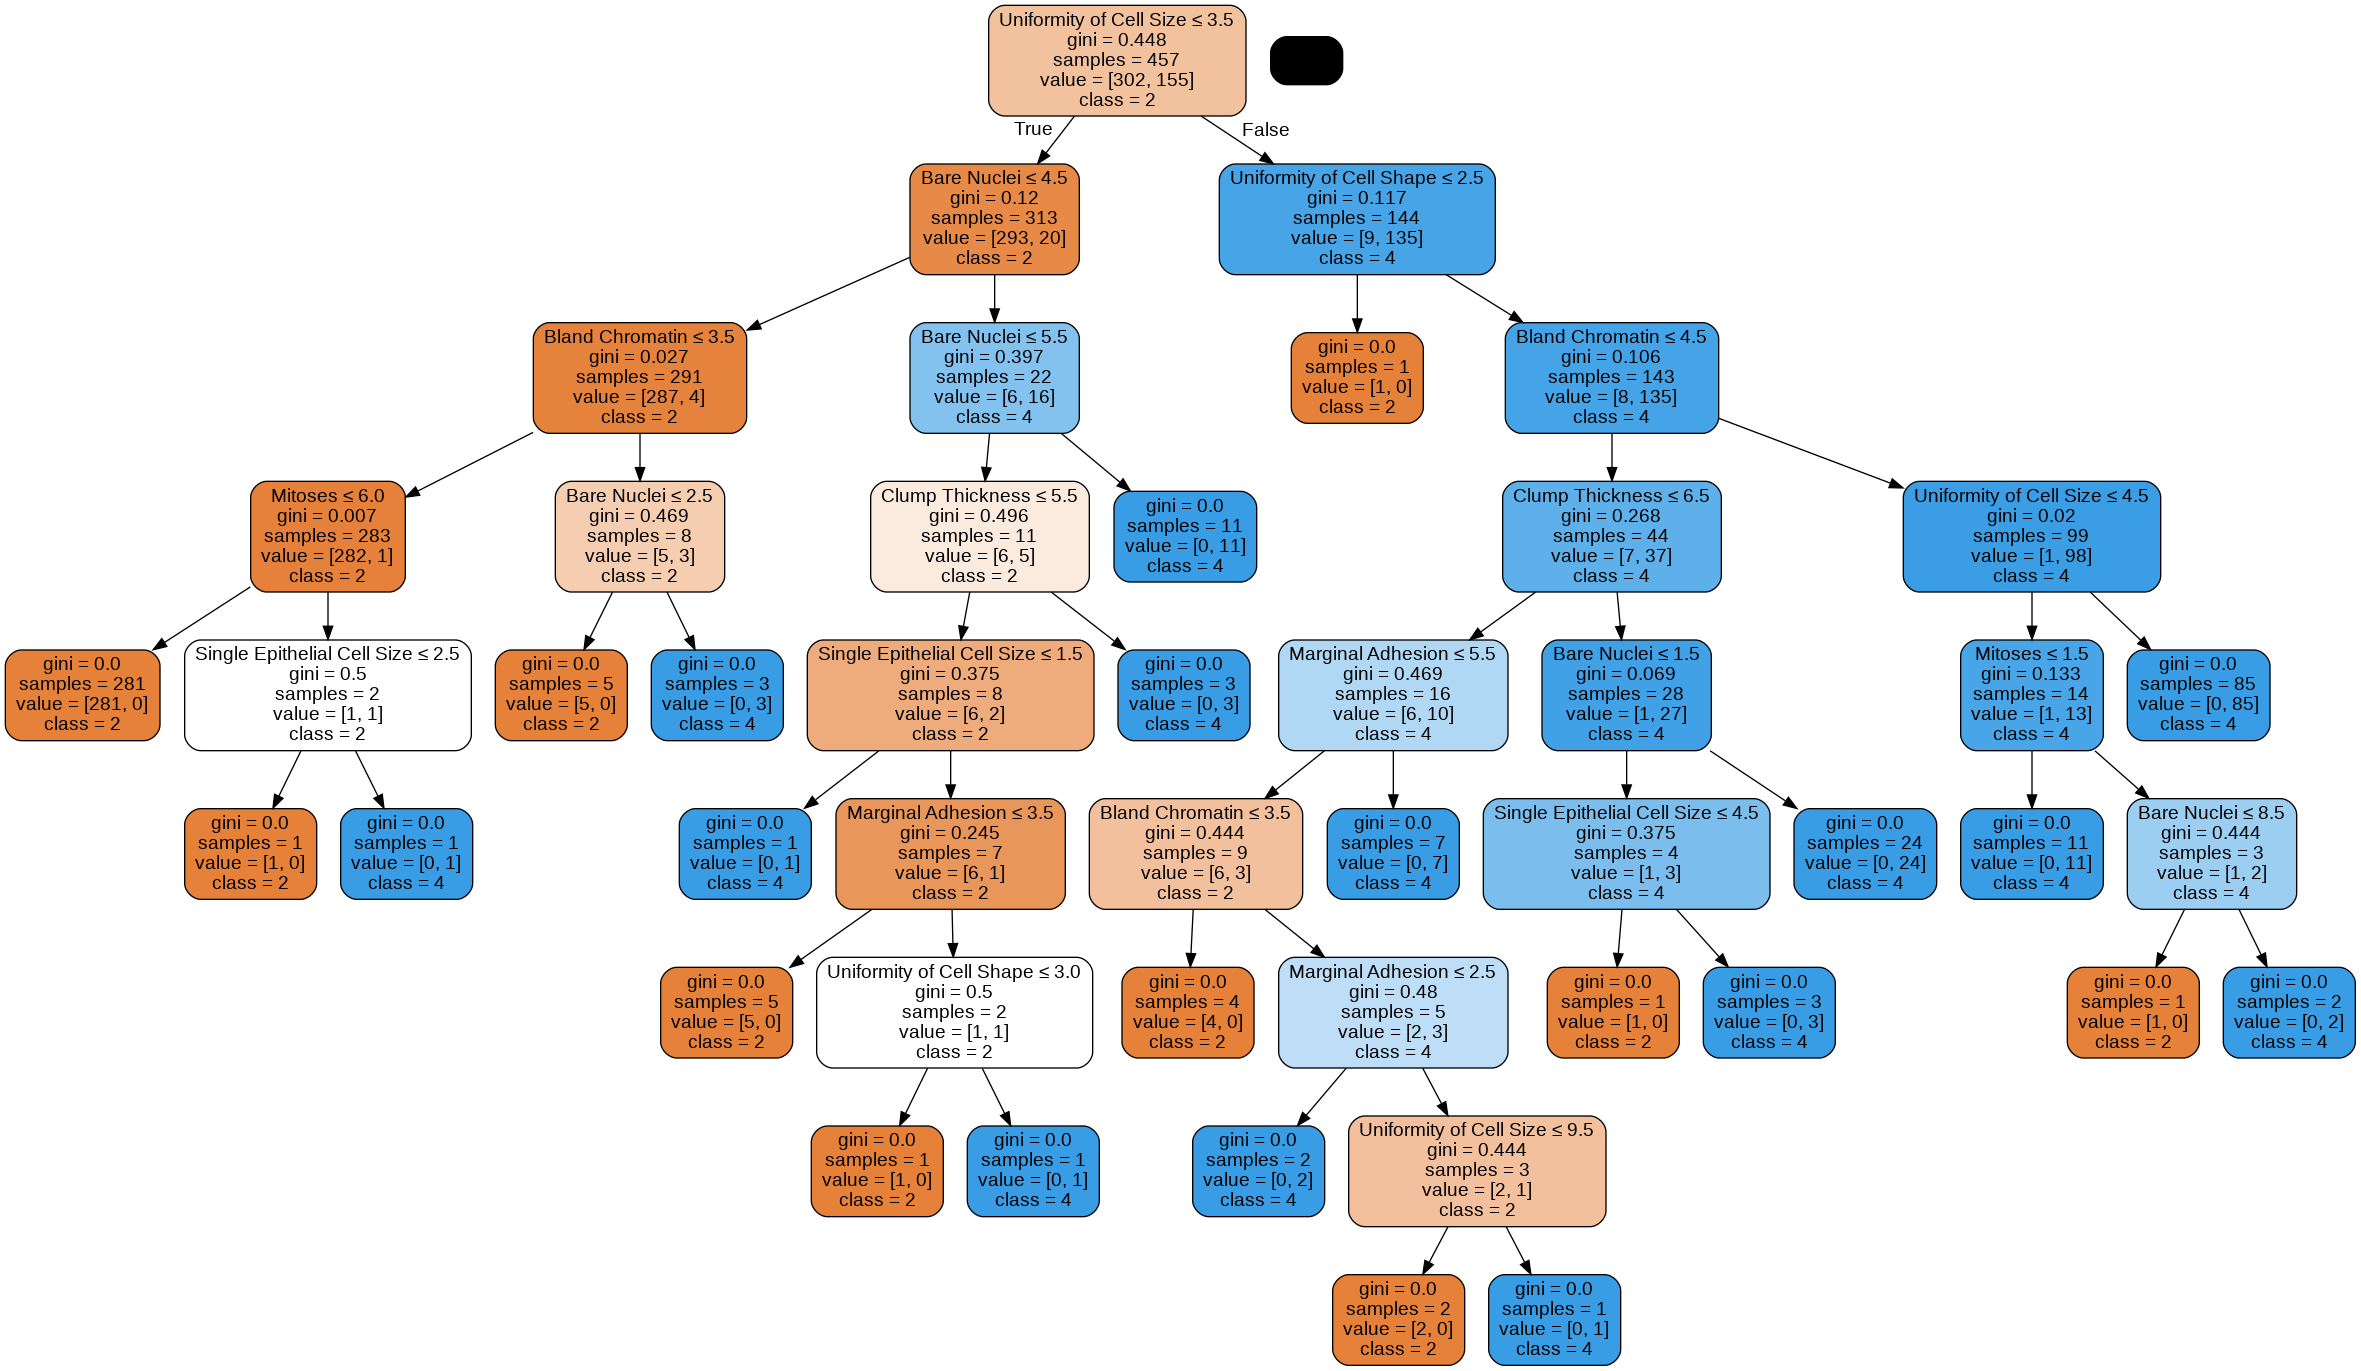

In [48]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = list(x.columns),class_names=['2','4'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

In [51]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [52]:
confusion_matrix(y_test, y_pred)

array([[138,   4],
       [  8,  76]])

In [53]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9469026548672567


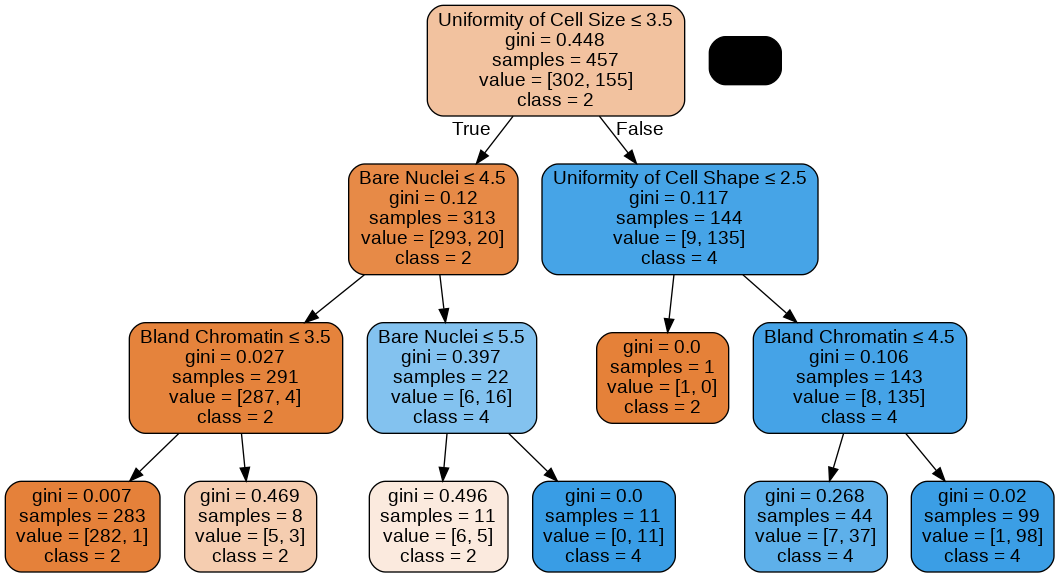

In [54]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = list(x.columns),class_names=['2','4'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

## Random forests

Random forests are an extention of decision trees that estimate a large number of trees (hence *forest*) on randomly resampled rows (hence *random*) of the training data set. Furthermore, each time a new decision node is added, it is only allowed to consider a random subsample of features. This limits the risk of overfitting. 

A single decision tree returns a classification without any assessment of uncertainty of prediction. Now, since we have a whole forest of decision trees, we can obtain a *classification probability*, defined as the number of trees that result in a particular classification, that we can use to quantify this uncertainty.   

**Exercise 2.** Fit a random forest to the training data set using the `RandomForestClassifier` function from the `scikit` package. Check if this algorithm allows you to get a better classification accuracy on the test data set. What if you limit the maximum depth of trees?  

For each observation from the test set, predict the probability that the tumor is malignant.  
Plot the probabilities on a histogram.  
Figure out an appropriate threshold so that if the probability is higher, the tumor is classified as malignant.  
Use this threshold to classify the observations and show the results using a confusion matrix.  

Obtain the importance of each variable (see the documentation of the `RandomForestClassifier` function). Visualize the importances on a horizontal bar plot. Is there a subset of variables that is the most important for prediction? Are there any variables that can be discarded without a significant loss in accuracy? Remove them, fit a random forest to the restricted data set, calculate a confusion matrix and compare it to the random forest fitted to the whole data set. What if you remove variables of the highest importance?   

In [57]:
clf=RandomForestClassifier(n_estimators=20)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9646017699115044


In [60]:
clf2=RandomForestClassifier(n_estimators=20, max_depth=4)
clf2.fit(x_train,y_train)
y_pred2=clf2.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))

Accuracy: 0.9601769911504425


In [66]:
preds = clf.predict_proba(x_test)

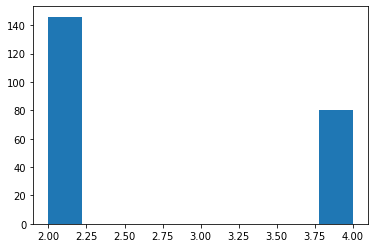

In [69]:
_ = plt.hist(y_pred, bins='auto')
plt.show()

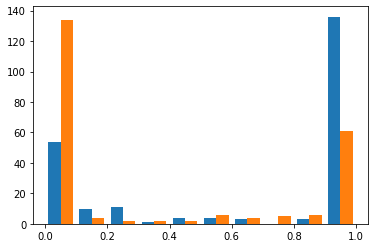

In [70]:
_ = plt.hist(preds, bins='auto')
plt.show()
# orange - class 4, blue - class 2

In [81]:
threshold = 0.1
y_pred_thr = (clf.predict_proba(x_test)[:, 1] > threshold).astype('float')
y_test_map = [1 if x == 4.0 else 0 for x in y_test]
confusion_matrix(y_test_map, y_pred_thr)

array([[136,   6],
       [  0,  84]])

In [84]:
feature_imp = pd.Series(clf.feature_importances_,index=x.columns).sort_values(ascending=False)
feature_imp

Uniformity of Cell Shape       0.334344
Bare Nuclei                    0.162605
Bland Chromatin                0.143167
Uniformity of Cell Size        0.125424
Single Epithelial Cell Size    0.079132
Normal Nucleoli                0.069275
Clump Thickness                0.039051
Marginal Adhesion              0.034492
Mitoses                        0.012509
dtype: float64

In [87]:
import plotly.graph_objects as go

fig = go.Figure(go.Bar(
            x=feature_imp,
            y=feature_imp.index,
            orientation='h'))

fig.show()

In [91]:
cols =[x for x in column_names if (x != 'Sample code number' and x != 'Class')]

In [94]:
for col in cols:
  new_cols = [x for x in cols if x != col]
  new_x_train = x_train[new_cols]
  new_x_test = x_test[new_cols]
  

  clf=RandomForestClassifier(n_estimators=20)
  clf.fit(new_x_train, y_train)
  new_y_pred=clf.predict(new_x_test)
  print(f'Accuracy without {col}: {metrics.accuracy_score(y_test, new_y_pred)}')
  print(confusion_matrix(y_test, new_y_pred))

Accuracy without Clump Thickness: 0.9513274336283186
[[139   3]
 [  8  76]]
Accuracy without Uniformity of Cell Size: 0.9557522123893806
[[140   2]
 [  8  76]]
Accuracy without Uniformity of Cell Shape: 0.9646017699115044
[[140   2]
 [  6  78]]
Accuracy without Marginal Adhesion: 0.9601769911504425
[[140   2]
 [  7  77]]
Accuracy without Single Epithelial Cell Size: 0.9690265486725663
[[140   2]
 [  5  79]]
Accuracy without Bare Nuclei: 0.9601769911504425
[[140   2]
 [  7  77]]
Accuracy without Bland Chromatin: 0.9601769911504425
[[140   2]
 [  7  77]]
Accuracy without Normal Nucleoli: 0.9646017699115044
[[140   2]
 [  6  78]]
Accuracy without Mitoses: 0.9513274336283186
[[140   2]
 [  9  75]]


<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60">

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'>


Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej".   
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>